# Preprocessing and clustering 3k PBMCs

In May 2017, this started out as a demonstration that Scanpy would allow to reproduce most of Seurat's ([Satija et al., 2015](https://doi.org/10.1038/nbt.3192)) [guided clustering tutorial](http://satijalab.org/seurat/pbmc3k_tutorial.html). We gratefully acknowledge the authors of Seurat for the tutorial. In the meanwhile, we have added and removed a few pieces.  
    
The data consists in *3k PBMCs from a Healthy Donor* and is freely available from 10x Genomics ([here](http://cf.10xgenomics.com/samples/cell-exp/1.1.0/pbmc3k/pbmc3k_filtered_gene_bc_matrices.tar.gz) from this [webpage](https://support.10xgenomics.com/single-cell-gene-expression/datasets/1.1.0/pbmc3k)). On a unix system, you can uncomment and run the following to download and unpack the data

In [ ]:
# !mkdir data
# !wget http://cf.10xgenomics.com/samples/cell-exp/1.1.0/pbmc3k/pbmc3k_filtered_gene_bc_matrices.tar.gz -O data/pbmc3k_filtered_gene_bc_matrices.tar.gz
# !cd data; tar -xzf pbmc3k_filtered_gene_bc_matrices.tar.gz

<div class="alert alert-info">

**Note**
    
Download the notebook by clicking on the _Edit on GitHub_ button. On GitHub, you can download using the _Raw_ button via right-click and _Save Link As_. Alternatively, download the whole [scanpy-tutorial](https://github.com/theislab/scanpy-tutorials) repository.

</div>  

<div class="alert alert-info">

**Note**
    
In Jupyter notebooks and lab, you can see the documentation for a python function by hitting ``SHIFT + TAB``. Hit it twice to expand the view.

</div>

In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import scipy as sp
import matplotlib.pyplot as plt

In [2]:
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_versions()
sc.settings.set_figure_params(dpi=80)

scanpy==1.4.5.post2 anndata==0.6.22.post1 umap==0.3.10 numpy==1.17.0 scipy==1.4.1 pandas==0.25.1 scikit-learn==0.21.3 statsmodels==0.10.1 python-igraph==0.7.1


In [3]:
results_file = './write/pbmc3k.h5ad'  # the file that will store the analysis results

In [4]:
adata = sc.read_10x_mtx(
    '/Users/student/Desktop/BP205B/HCC_AA/',  # the directory with the `.mtx` file
    var_names='gene_symbols',                  # use gene symbols for the variable names (variables-axis index)
    cache=True)                                # write a cache file for faster subsequent reading

... reading from cache file cache/Users-student-Desktop-BP205B-HCC_AA-matrix.h5ad


In [5]:
barcode_meta = pd.read_csv("./AA_barcode_identities.csv", sep=',', index_col =1)

barcode_meta.index = barcode_meta.apply(lambda x: x.name + "-1", axis=1)

print(len(adata.obs.index), len(np.intersect1d(adata.obs.index, barcode_meta.index)))
barcode_meta = barcode_meta.replace({'GCCAGTTA':'LM2-B','CACTGTAG':'Parental','TGCCGTGG':'LM2-C'})
barcode_meta

4151 3568


,Unnamed: 0,multiseq_barcode
GGATGTTCAGTACACT-1,0,LM2-B
TTAGGACCAATGGAGC-1,1,LM2-C
CGCTGGAAGCTCTCGG-1,2,Parental
TACGGATAGGCGATAC-1,3,Parental
CCTAAAGGTGCTTCTC-1,4,LM2-C
...,...,...
TGACTTTAGCTGGAAC-1,3563,LM2-B
TGGGAAGGTTAAAGTG-1,3564,LM2-B
AACTGGTTCACAAACC-1,3565,LM2-B
GACTGCGCAGCTGCTG-1,3566,LM2-B


In [6]:
adata.var_names_make_unique()  # this is unnecessary if using `var_names='gene_ids'` in `sc.read_10x_mtx`

In [7]:
adata.obs['multiseq'] = barcode_meta.loc[adata.obs.index, 'multiseq_barcode']

/usr/local/lib/python3.7/site-packages/pandas/core/indexing.py:961: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  return getattr(section, self.name)[new_key]


In [9]:
adata.obs

,multiseq
0,
AAACCTGCAATCGGTT-1,LM2-C
AAACCTGGTAGGCATG-1,LM2-B
AAACCTGGTCGTGGCT-1,LM2-B
AAACCTGGTTCTGGTA-1,Parental
AAACCTGGTTGTCTTT-1,Parental
...,...
TTTGTCAGTTCAGACT-1,LM2-C
TTTGTCAGTTGCGCAC-1,LM2-B
TTTGTCATCCTCGCAT-1,Parental


## Preprocessing

Show those genes that yield the highest fraction of counts in each single cells, across all cells.

normalizing counts per cell
    finished (0:00:00)


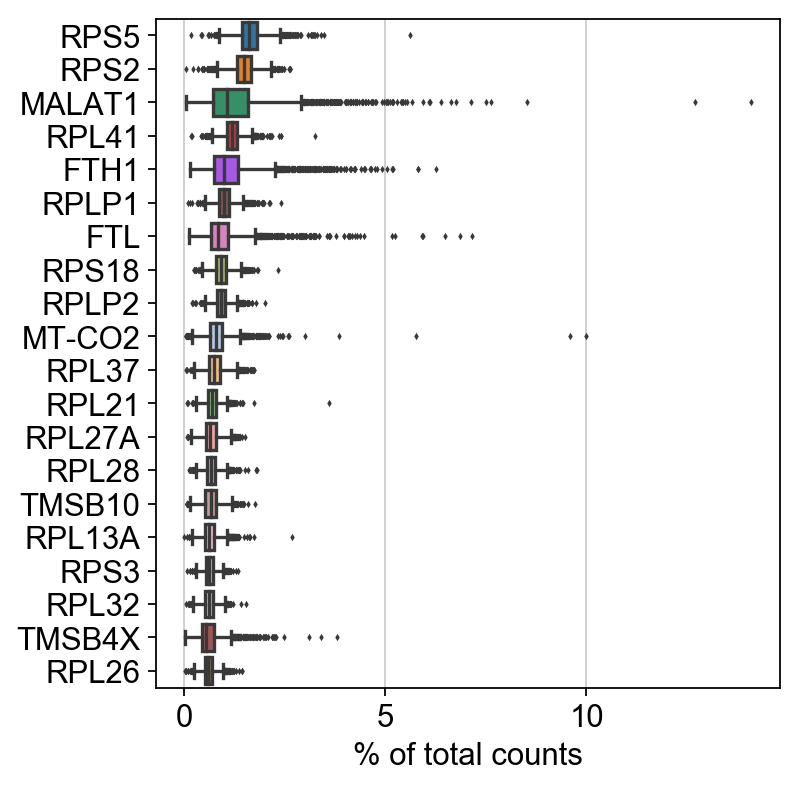

In [10]:
sc.pl.highest_expr_genes(adata, n_top=20, )

Basic filtering.

In [11]:
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

filtered out 16935 genes that are detected in less than 3 cells


Let us assemple some information about mitochondrial genes, which are important for quality control.

Citing from "Simple Single Cell" workflows [(Lun, McCarthy & Marioni, 2017)](https://master.bioconductor.org/packages/release/workflows/html/simpleSingleCell.html#examining-gene-level-metrics):

> High proportions are indicative of poor-quality cells (Islam et al. 2014; Ilicic et al. 2016), possibly because of loss of cytoplasmic RNA from perforated cells. The reasoning is that mitochondria are larger than individual transcript molecules and less likely to escape through tears in the cell membrane.

Note you can also use the function `pp.calculate_qc_metrics` to compute the fraction of mitochondrial genes and additional measures.

In [12]:
mito_genes = adata.var_names.str.startswith('MT-')
# for each cell compute fraction of counts in mito genes vs. all genes
# the `.A1` is only necessary as X is sparse (to transform to a dense array after summing)
adata.obs['percent_mito'] = np.sum(
    adata[:, mito_genes].X, axis=1).A1 / np.sum(adata.X, axis=1).A1
# add the total counts per cell as observations-annotation to adata
adata.obs['n_counts'] = adata.X.sum(axis=1).A1

A violin plot of the computed quality measures.

... storing 'multiseq' as categorical


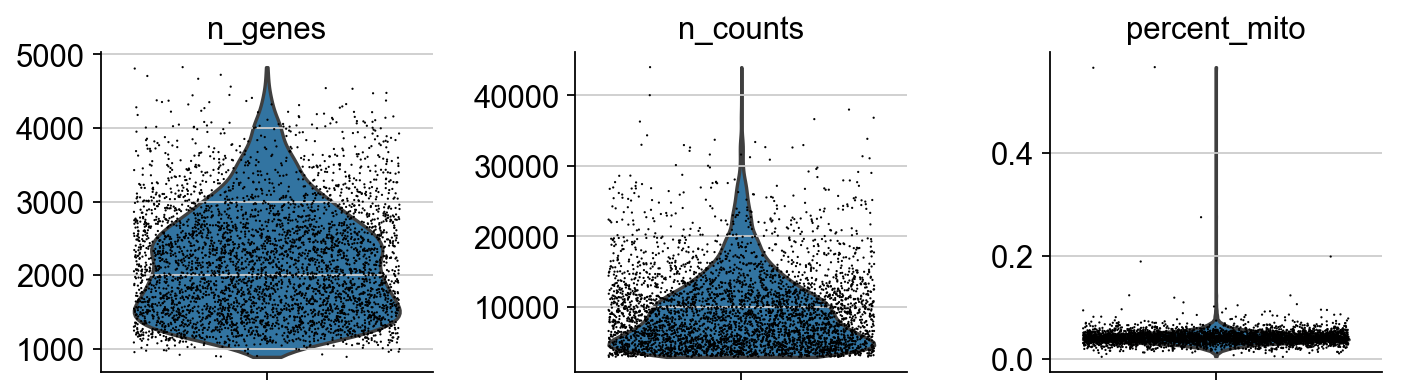

In [13]:
sc.pl.violin(adata, ['n_genes', 'n_counts', 'percent_mito'],
             jitter=0.4, multi_panel=True)

Remove cells that have too many mitochondrial genes expressed or too many total counts.

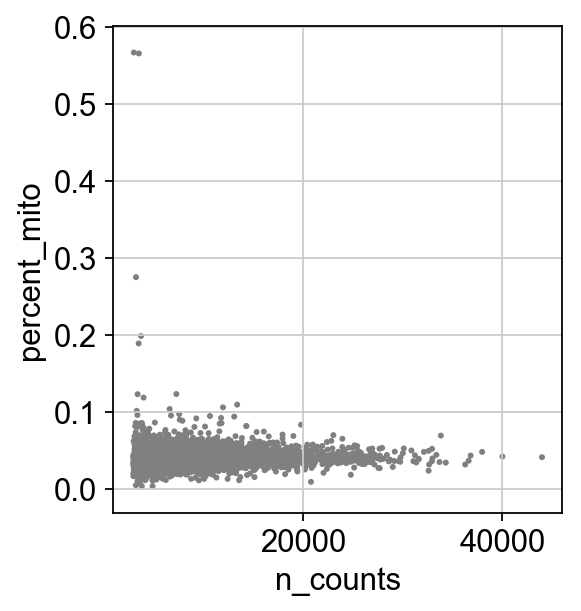

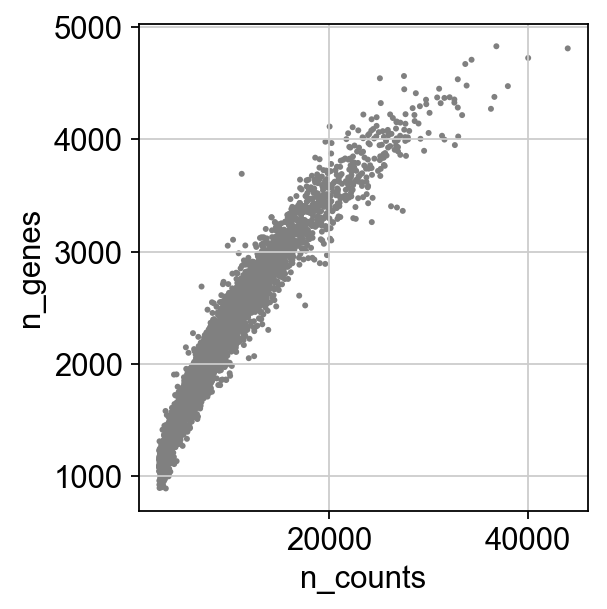

In [14]:
sc.pl.scatter(adata, x='n_counts', y='percent_mito')
sc.pl.scatter(adata, x='n_counts', y='n_genes')

filter out cells without multiseq barcode

In [15]:
adata = adata[adata.obs.multiseq != 'nan', :]

Actually do the filtering.

In [16]:
adata = adata[adata.obs.n_genes < 6000, :]
adata = adata[adata.obs.percent_mito < 0.1, :]

Total-count normalize (library-size correct) the data matrix $\mathbf{X}$ to 10,000 reads per cell, so that counts become comparable among cells.

In [17]:
sc.pp.normalize_total(adata, target_sum=1e4)

normalizing counts per cell


Trying to set attribute `.X` of view, making a copy.


    finished (0:00:05)


Logarithmize the data.

In [18]:
sc.pp.log1p(adata)

/usr/local/lib/python3.7/site-packages/scanpy/preprocessing/_simple.py:298: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(data)


Set the `.raw` attribute of AnnData object to the normalized and logarithmized raw gene expression for later use in differential testing and visualizations of gene expression. This simply freezes the state of the AnnData object.

While many people consider the normalized data matrix as the "relevant data" for visualization and differential testing, some would prefer to store the unnormalized data in `.raw`.

In [19]:
adata.raw = adata

<div class="alert alert-info">

**Note**
    
If you don't proceed below with correcting the data with `sc.pp.regress_out` and scaling it via `sc.pp.scale`, you can also get away without using `.raw` at all.

The result of the following highly-variable-genes detection is stored as an annotation in `.var.highly_variable` and auto-detected by PCA and hence, `sc.pp.neighbors` and subsequent manifold/graph tools. In that case, the step *actually do the filtering* below is unnecessary, too.

</div>

Identify highly-variable genes.

In [20]:
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)

extracting highly variable genes
    finished (0:00:01)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


In [21]:
adata.var[adata.var.highly_variable == True]

,gene_ids,n_cells,highly_variable,means,dispersions,dispersions_norm
RP11-206L10.9,ENSG00000237491,79,True,0.024490,0.676405,1.528351
SAMD11,ENSG00000187634,813,True,0.235925,0.497450,0.630243
HES4,ENSG00000188290,3221,True,1.238371,0.790561,0.755106
ISG15,ENSG00000187608,3494,True,1.371338,0.841917,0.525219
MORN1,ENSG00000116151,119,True,0.032271,0.472974,0.507410
...,...,...,...,...,...,...
COL18A1,ENSG00000182871,77,True,0.023273,0.513804,0.712315
MCM3AP-AS1,ENSG00000215424,84,True,0.024707,0.532126,0.804271
YBEY,ENSG00000182362,234,True,0.067568,0.515224,0.719446
MT-ND6,ENSG00000198695,2618,True,0.926476,0.777450,1.442181


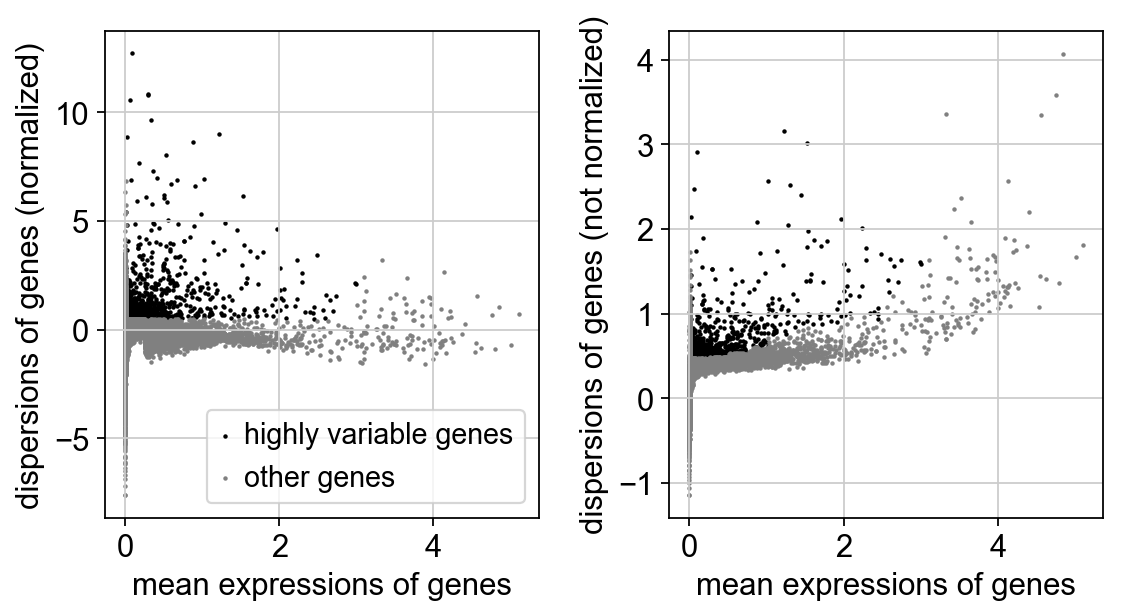

In [22]:
sc.pl.highly_variable_genes(adata)

Actually do the filtering.

In [23]:
adata = adata[:, adata.var.highly_variable]

Regress out effects of total counts per cell and the percentage of mitochondrial genes expressed. Scale the data to unit variance.

In [24]:
sc.pp.regress_out(adata, ['n_counts', 'percent_mito'])

regressing out ['n_counts', 'percent_mito']
    sparse input is densified and may lead to high memory use
    finished (0:00:06)


Scale each gene to unit variance. Clip values exceeding standard deviation 10. 

In [25]:
sc.pp.scale(adata, max_value=10)

## Regress out cell cycle genes

In [26]:
import urllib.request
cell_cycle_genes = [x.strip().decode('utf-8') for x in urllib.request.urlopen('https://raw.githubusercontent.com/theislab/scanpy_usage/master/180209_cell_cycle/data/regev_lab_cell_cycle_genes.txt')]
s_genes = cell_cycle_genes[:43]
g2m_genes = cell_cycle_genes[43:]
cell_cycle_genes = [x for x in cell_cycle_genes if x in adata.var_names]


In [27]:
sc.tl.score_genes_cell_cycle(adata, s_genes=s_genes, g2m_genes=g2m_genes)

calculating cell cycle phase
computing score 'S_score'
    finished: added
    'S_score', score of gene set (adata.obs) (0:00:00)
computing score 'G2M_score'
    finished: added
    'G2M_score', score of gene set (adata.obs) (0:00:00)
-->     'phase', cell cycle phase (adata.obs)


computing PCA with n_comps = 50
    on highly variable genes
    finished (0:00:00)


... storing 'phase' as categorical


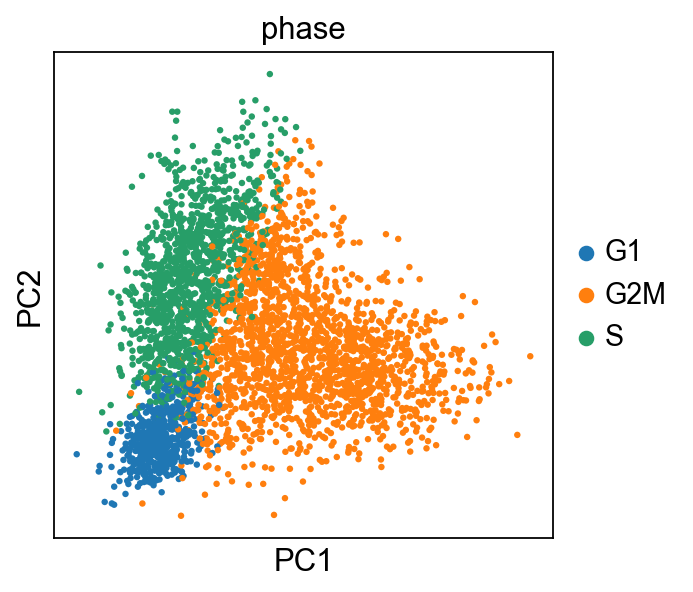

In [28]:
adata_cc_genes = adata[:, cell_cycle_genes]
sc.tl.pca(adata_cc_genes)
sc.pl.pca_scatter(adata_cc_genes, color='phase')


In [29]:
sc.pp.regress_out(adata, ['S_score', 'G2M_score'])
sc.pp.scale(adata)

regressing out ['S_score', 'G2M_score']


... storing 'phase' as categorical


    finished (0:00:05)


computing PCA with n_comps = 50
    on highly variable genes
    finished (0:00:00)


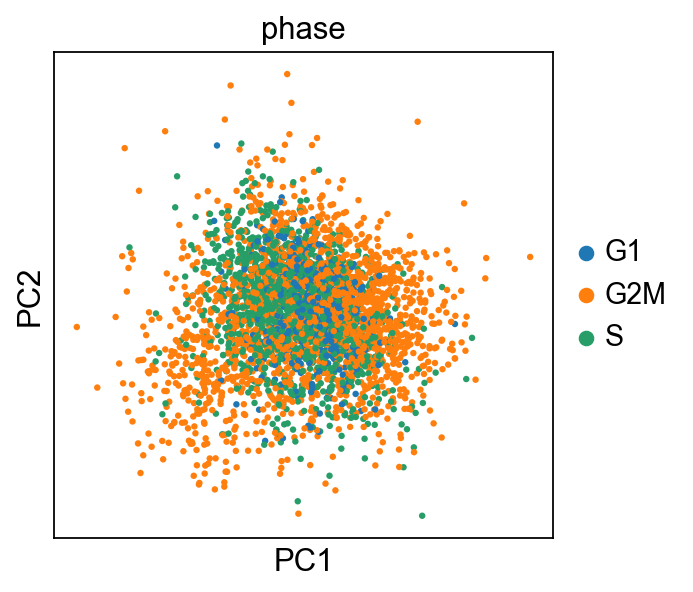

In [30]:
adata_cc_genes = adata[:, cell_cycle_genes]
sc.tl.pca(adata_cc_genes)
sc.pl.pca_scatter(adata_cc_genes, color='phase')

## Principal component analysis

Reduce the dimensionality of the data by running principal component analysis (PCA), which reveals the main axes of variation and denoises the data.

In [31]:
sc.tl.pca(adata, svd_solver='arpack')

computing PCA with n_comps = 50
    on highly variable genes
    finished (0:00:00)


In [32]:
adata

AnnData object with n_obs × n_vars = 3559 × 1748 
    obs: 'multiseq', 'n_genes', 'percent_mito', 'n_counts', 'S_score', 'G2M_score', 'phase'
    var: 'gene_ids', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'

We can make a scatter plot in the PCA coordinates, but we will not use that later on.

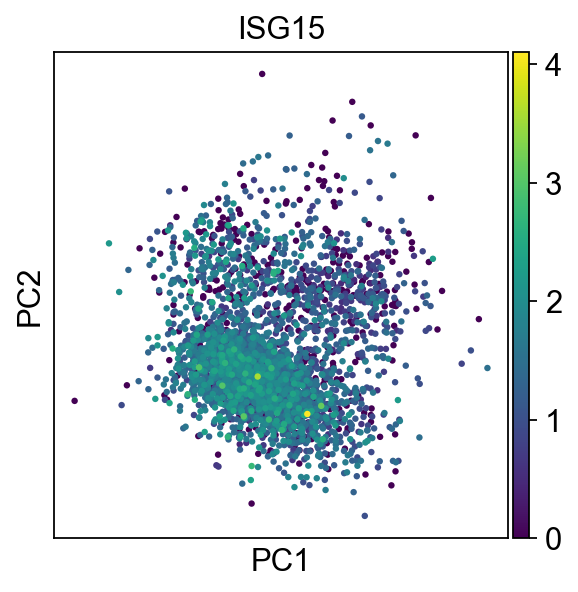

In [33]:
sc.pl.pca(adata, color='ISG15')

Let us inspect the contribution of single PCs to the total variance in the data. This gives us information about how many PCs we should consider in order to compute the neighborhood relations of cells, e.g. used in the clustering function  `sc.tl.louvain()` or tSNE `sc.tl.tsne()`. In our experience, often, a rough estimate of the number of PCs does fine.

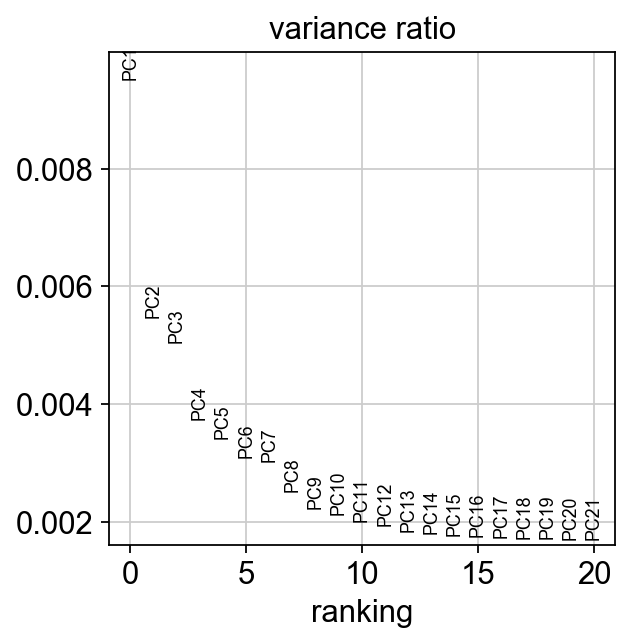

In [34]:
sc.pl.pca_variance_ratio(adata, log=False,n_pcs = 20)

Save the result.

In [35]:
adata.write(results_file)

## Computing the neighborhood graph

Let us compute the neighborhood graph of cells using the PCA representation of the data matrix. You might simply use default values here. For the sake of reproducing Seurat's results, let's take the following values.

In [36]:
sc.pp.neighbors(adata, n_neighbors=10, knn = True, n_pcs=13)

computing neighbors
    using 'X_pca' with n_pcs = 13
    finished: added to `.uns['neighbors']`
    'distances', distances for each pair of neighbors
    'connectivities', weighted adjacency matrix (0:00:02)


## Embedding the neighborhood graph

We advertise embedding the graph in 2 dimensions using UMAP ([McInnes et al., 2018](https://arxiv.org/abs/1802.03426)), see below. It is  potentially more faithful to the global connectivity of the manifold than tSNE, i.e., it better preservers trajectories. In some ocassions, you might still observe disconnected clusters and similar connectivity violations. They can usually be remedied by running:

```
tl.paga(adata)
pl.paga(adata, plot=False)  # remove `plot=False` if you want to see the coarse-grained graph
tl.umap(adata, init_pos='paga')
```

In [37]:
sc.tl.umap(adata)

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:05)


## Classification according to neighbourhood graphs

In [38]:
LM_percent = []
Parental_percent = []
mask = []
for i in range(0,len(adata)):
    if adata.obs.iloc[i]['multiseq'] == "Parental":
        neighbours = adata.obs[adata.uns['neighbors']['distances'].toarray()[i]!=0]
        num_LM = len(neighbours[neighbours['multiseq'] != "Parental"])
        LM_percent.append(num_LM/9.0)
        if num_LM/9.0 >= 0.5:
            mask.append("p-H")
        else:
            mask.append("p-L")
    else:
        neighbours = adata.obs[adata.uns['neighbors']['distances'].toarray()[i]!=0]
        num_parental = len(neighbours[neighbours['multiseq'] != "Parental"])
        Parental_percent.append(num_parental/9.0)
        if num_parental/9.0 <0.7:
            mask.append("LM-L")
        else:
            mask.append("LM-H")
        

In [40]:
adata.obs["status"] = mask

In [41]:
adata.obs

,multiseq,n_genes,percent_mito,n_counts,S_score,G2M_score,phase,status
0,,,,,,,,
AAACCTGCAATCGGTT-1,LM2-C,1606,0.033388,4912.0,0.021722,0.838932,G2M,LM-H
AAACCTGGTAGGCATG-1,LM2-B,2380,0.031651,10047.0,0.346711,-0.000615,S,LM-H
AAACCTGGTCGTGGCT-1,LM2-B,3359,0.041147,18106.0,0.114217,0.377306,G2M,LM-H
AAACCTGGTTCTGGTA-1,Parental,3152,0.039965,15839.0,0.441143,0.028078,S,p-L
AAACCTGGTTGTCTTT-1,Parental,2588,0.043345,14304.0,-0.162082,-0.177903,G1,p-L
...,...,...,...,...,...,...,...,...
TTTGTCAGTTCAGACT-1,LM2-C,1691,0.038537,5086.0,0.416862,0.490074,G2M,LM-H
TTTGTCAGTTGCGCAC-1,LM2-B,1732,0.035943,5147.0,-0.182911,0.539860,G2M,LM-H
TTTGTCATCCTCGCAT-1,Parental,1693,0.011504,4955.0,-0.057673,0.458768,G2M,p-L


... storing 'status' as categorical


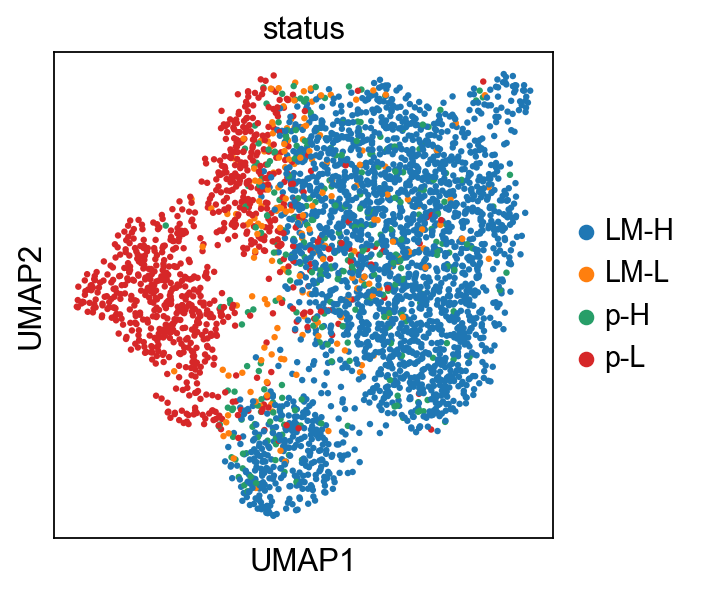

In [42]:
sc.pl.umap(adata, color=['status'])

Text(0.5, 0, 'Parental_Percent')

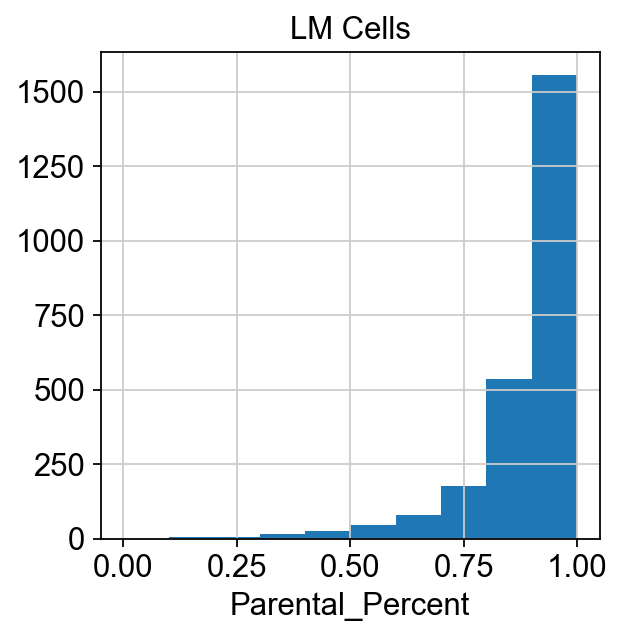

In [43]:
plt.hist(Parental_percent,bins = 10)
plt.title("LM Cells")
plt.xlabel("Parental_Percent")

Text(0.5, 0, 'LM_Percent')

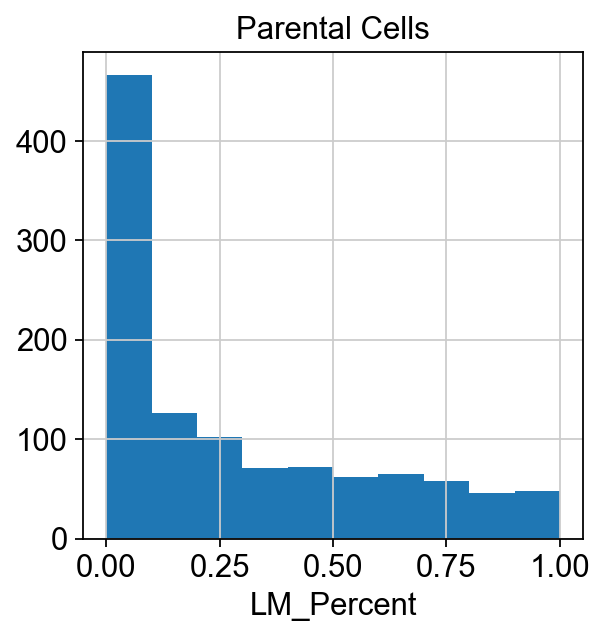

In [44]:
plt.hist(LM_percent,bins = 10)
plt.title("Parental Cells")
plt.xlabel("LM_Percent")

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:05)


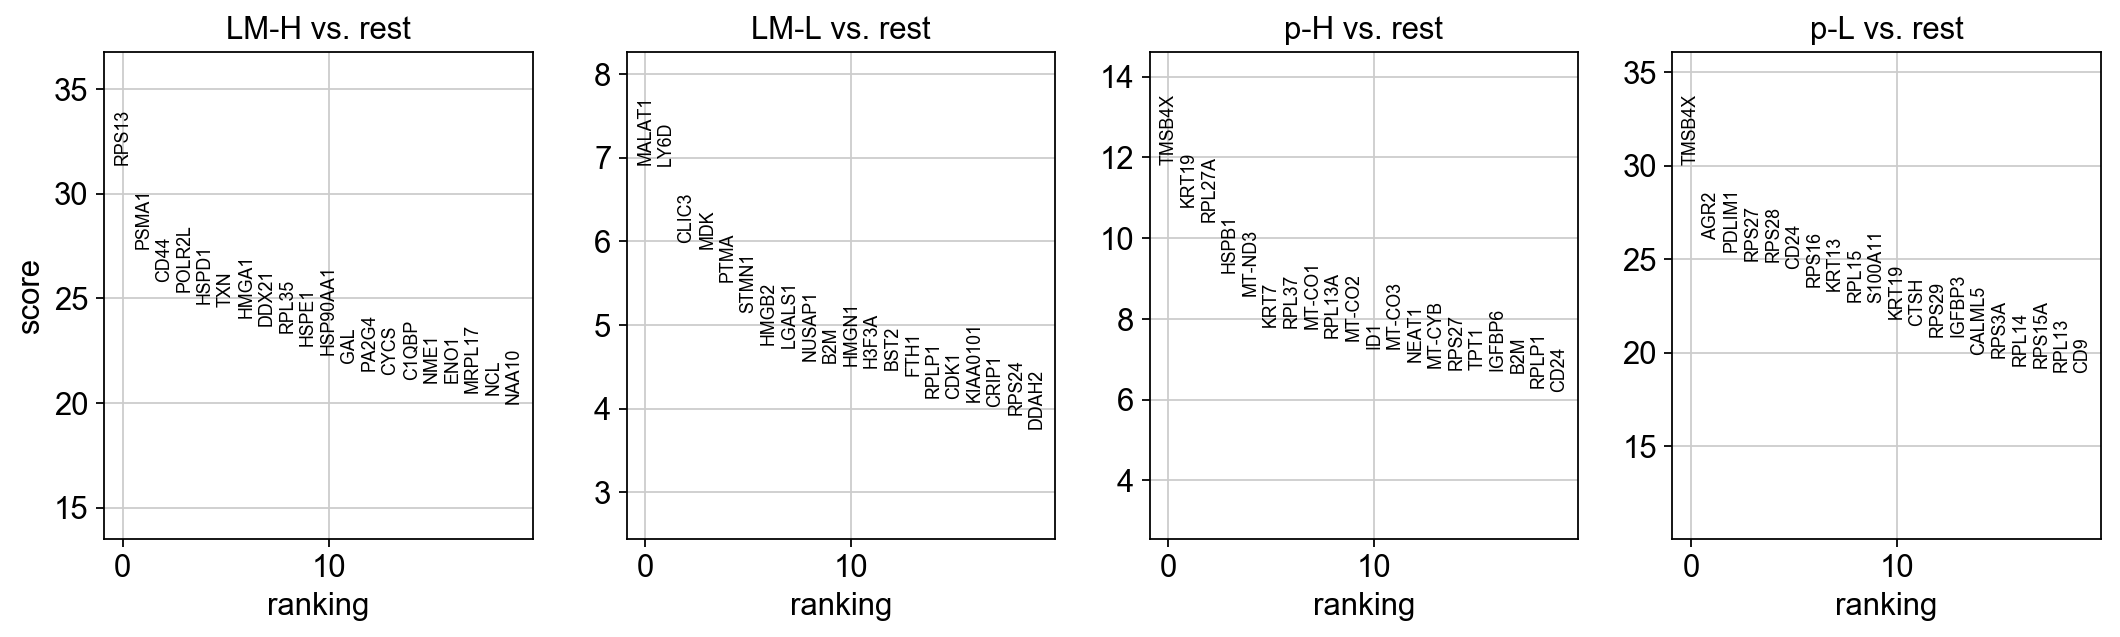

In [45]:
sc.tl.rank_genes_groups(adata, 'status', method='wilcoxon')
sc.pl.rank_genes_groups(adata, n_genes=20,sharey = False)

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:01)


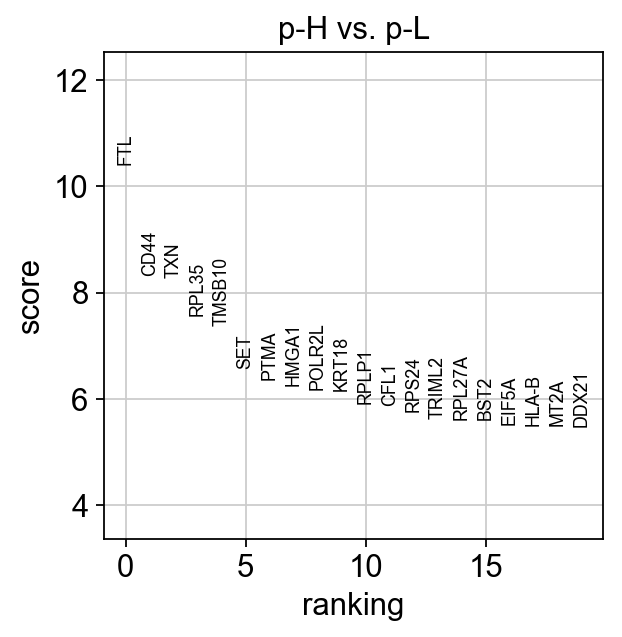

In [46]:
sc.tl.rank_genes_groups(adata, 'status', groups=["p-H"], reference='p-L', method='wilcoxon')
sc.pl.rank_genes_groups(adata, groups=["p-H"], n_genes=20)

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:03)


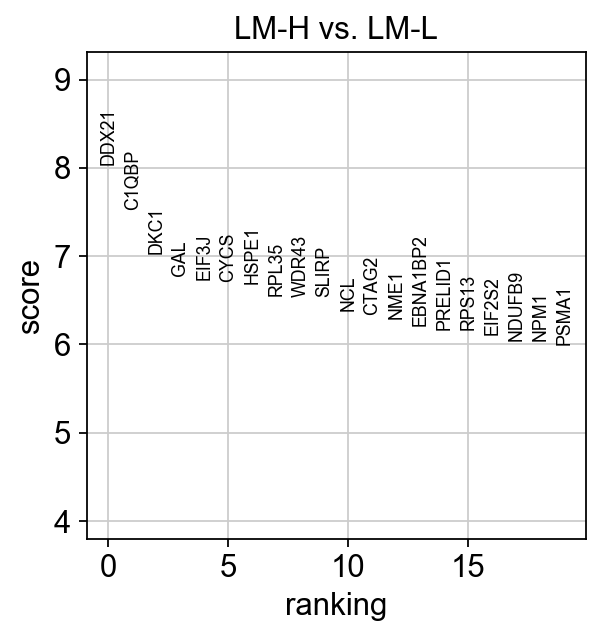

In [47]:
sc.tl.rank_genes_groups(adata, 'status', groups=["LM-H"], reference='LM-L', method='wilcoxon')
sc.pl.rank_genes_groups(adata, groups=["LM-H"], n_genes=20)

In [48]:
adata.uns['rank_genes_groups']['names']['LM-H']


array(['DDX21', 'C1QBP', 'DKC1', 'GAL', 'EIF3J', 'CYCS', 'HSPE1', 'RPL35',
       'WDR43', 'SLIRP', 'NCL', 'CTAG2', 'NME1', 'EBNA1BP2', 'PRELID1',
       'RPS13', 'EIF2S2', 'NDUFB9', 'NPM1', 'PSMA1', 'NPM3', 'RPL10',
       'HSPD1', 'CCT7', 'PSMD14', 'PDCD5', 'ENO1', 'BCYRN1', 'KRT18',
       'RAN', 'GLRX3', 'POMP', 'CYC1', 'NAA10', 'SNRPF', 'MRPL13', 'PPA1',
       'CMSS1', 'HSP90AA1', 'HSP90AB1', 'RANBP1', 'PA2G4', 'POLR2L',
       'ZNF593', 'CACYBP', 'SET', 'BCCIP', 'NHP2', 'SNRPD3', 'MRPL17',
       'SERBP1', 'SNRPG', 'SNRPE', 'SSB', 'LDHA', 'CD3EAP', 'HMGA1',
       'AIMP1', 'PPM1G', 'SRM', 'CHCHD10', 'RPS5', 'CEBPZ', 'C19orf70',
       'MT-ND1', 'TXN', 'GTPBP4', 'EIF5', 'BNIP3', 'NOP56', 'FOSL1',
       'PSMB5', 'MT-ND2', 'NIFK', 'NCBP2', 'ATP5G3', 'PFDN2', 'RPL22L1',
       'EZR', 'GCSH', 'ATP5G1', 'EBPL', 'DCTPP1', 'COA4', 'MTCH2', 'IER3',
       'TOMM22', 'PHB', 'DRAP1', 'TIMM10', 'PSMA5', 'HSPA8', 'MRPL33',
       'TNFRSF12A', 'NDUFAF4', 'SRSF9', 'RUVBL1', 'GADD45GIP1', 'RPL3

## Clustering the whole dataset

As Seurat and many others, we recommend the Leiden graph-clustering method (community detection based on optimizing modularity) by [Traag *et al.* (2018)](https://scanpy.readthedocs.io/en/latest/references.html#traag18). Note that Leiden clustering directly clusters the neighborhood graph of cells, which we already computed in the previous section.

In [49]:
sc.tl.leiden(adata)

running Leiden clustering
    finished: found 11 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)


Plot the clusters, which agree quite well with the result of Seurat.

In [50]:
x = adata.obs.groupby(by = ['leiden', 'multiseq']).size() / adata.obs.groupby(by = 'leiden').size()

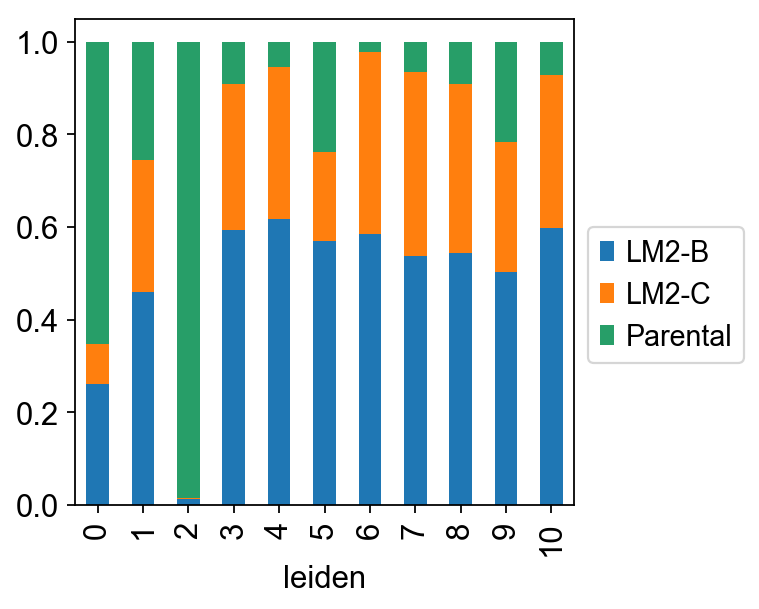

In [51]:
ax = x.unstack().plot(kind='bar', stacked = True)
ax.legend(bbox_to_anchor=(1, .6))
ax.grid(b=None)

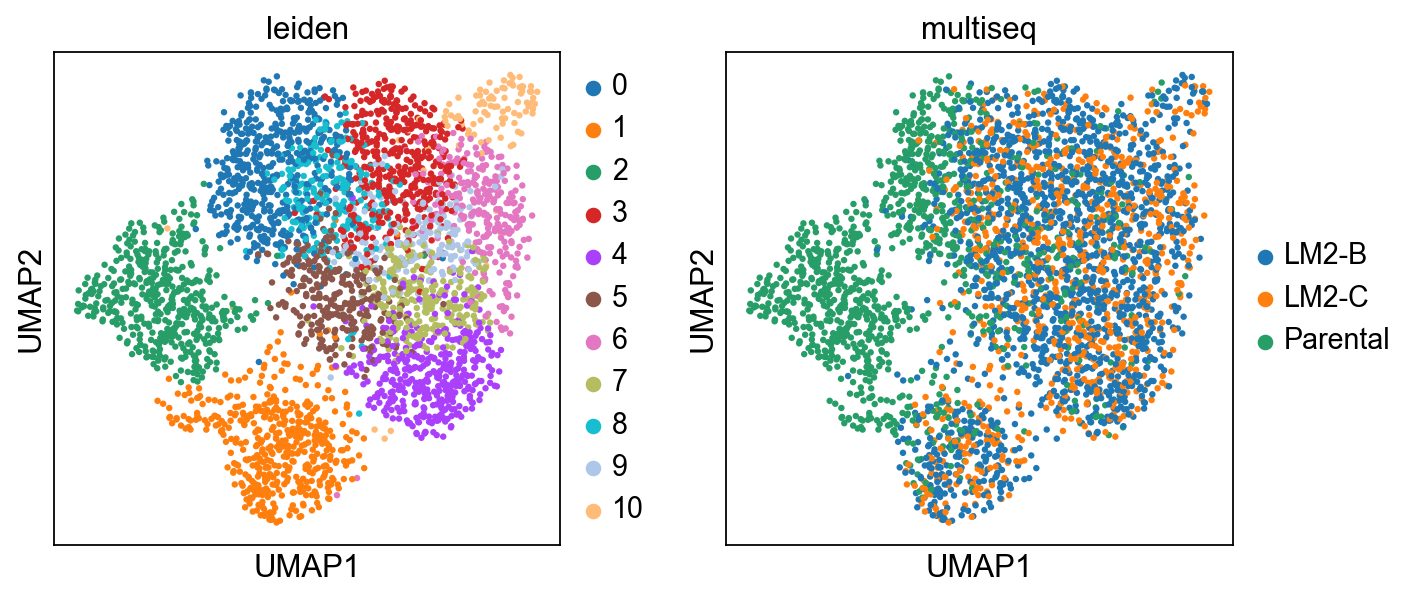

In [52]:
sc.pl.umap(adata, color=['leiden','multiseq'])

Save the result.

In [53]:
adata.write(results_file)

## Incorporate clusteing results into metastatic status

In [59]:
mask1 = []
for num in adata.obs['leiden']:
    mask1.append(num)

In [65]:
mask2 = []
i = 0
for cell in adata.obs['status']:
    if cell.startswith('LM'):
        mask2.append(mask1[i])
    else:
        mask2.append(cell)
    i += 1

In [66]:
adata.obs['new_status'] = mask2

In [67]:
adata.obs

,multiseq,n_genes,percent_mito,n_counts,S_score,G2M_score,phase,status,leiden,new_status
0,,,,,,,,,,
AAACCTGCAATCGGTT-1,LM2-C,1606,0.033388,4912.0,0.021722,0.838932,G2M,LM-H,1,1
AAACCTGGTAGGCATG-1,LM2-B,2380,0.031651,10047.0,0.346711,-0.000615,S,LM-H,7,7
AAACCTGGTCGTGGCT-1,LM2-B,3359,0.041147,18106.0,0.114217,0.377306,G2M,LM-H,6,6
AAACCTGGTTCTGGTA-1,Parental,3152,0.039965,15839.0,0.441143,0.028078,S,p-L,2,p-L
AAACCTGGTTGTCTTT-1,Parental,2588,0.043345,14304.0,-0.162082,-0.177903,G1,p-L,2,p-L
...,...,...,...,...,...,...,...,...,...,...
TTTGTCAGTTCAGACT-1,LM2-C,1691,0.038537,5086.0,0.416862,0.490074,G2M,LM-H,3,3
TTTGTCAGTTGCGCAC-1,LM2-B,1732,0.035943,5147.0,-0.182911,0.539860,G2M,LM-H,5,5
TTTGTCATCCTCGCAT-1,Parental,1693,0.011504,4955.0,-0.057673,0.458768,G2M,p-L,2,p-L


In [68]:
adata.obs[adata.obs['new_status'] == '1']

,multiseq,n_genes,percent_mito,n_counts,S_score,G2M_score,phase,status,leiden,new_status
0,,,,,,,,,,
AAACCTGCAATCGGTT-1,LM2-C,1606,0.033388,4912.0,0.021722,0.838932,G2M,LM-H,1,1
AAACGGGCAAGTTGTC-1,LM2-B,1915,0.042451,6431.0,-0.081727,0.180912,G2M,LM-H,1,1
AAAGATGGTCGGCACT-1,LM2-B,1422,0.031329,3958.0,0.135920,-0.119532,S,LM-H,1,1
AAAGCAACAGTATGCT-1,LM2-C,1862,0.052088,6585.0,-0.116714,0.593590,G2M,LM-H,1,1
AAAGCAAGTACCTACA-1,LM2-B,1691,0.029810,5468.0,-0.084277,1.024443,G2M,LM-H,1,1
...,...,...,...,...,...,...,...,...,...,...
TTGTAGGGTGGTCTCG-1,LM2-B,1587,0.037641,5579.0,-0.208237,0.009375,G2M,LM-L,1,1
TTTATGCAGTGTTTGC-1,LM2-B,1875,0.020521,6530.0,0.022209,0.269589,G2M,LM-L,1,1
TTTCCTCAGCCCGAAA-1,LM2-B,1570,0.022420,4505.0,0.112502,0.014160,S,LM-H,1,1


... storing 'new_status' as categorical


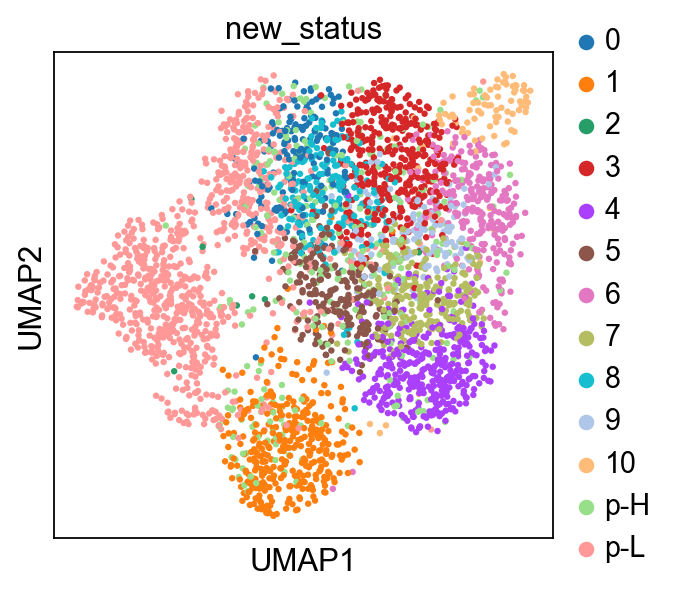

In [69]:
sc.pl.umap(adata, color=['new_status'])

## NQO1 gene

In [70]:
adata_Parental = adata[adata.obs.multiseq == 'Parental', :]

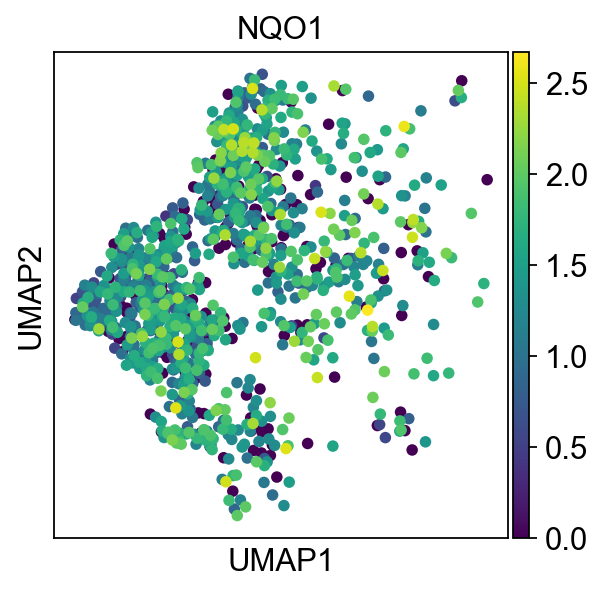

In [71]:
sc.pl.umap(adata_Parental,color = 'NQO1')

## Finding marker genes

Let us compute a ranking for the highly differential genes in each cluster. For this, by default, the `.raw` attribute of AnnData is used in case it has been initialized before. The simplest and fastest method to do so is the t-test.

In [ ]:
sc.tl.rank_genes_groups(adata, 'multiseq', method='t-test')
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

In [ ]:
sc.settings.verbosity = 2  # reduce the verbosity

The result of a [Wilcoxon rank-sum (Mann-Whitney-U)](https://de.wikipedia.org/wiki/Wilcoxon-Mann-Whitney-Test) test is very similar. We recommend using the latter in publications, see e.g., [Sonison & Robinson (2018)](https://doi.org/10.1038/nmeth.4612). You might also consider much more powerful differential testing packages like MAST, limma, DESeq2 and, for python, the recent diffxpy.

In [ ]:
sc.tl.rank_genes_groups(adata, 'multiseq', method='wilcoxon')
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

Save the result.

In [ ]:
adata.write(results_file)

As an alternative, let us rank genes using logistic regression. For instance, this has been suggested by [Natranos et al. (2018)](https://doi.org/10.1101/258566). The essential difference is that here, we use a multi-variate appraoch whereas conventional differential tests are uni-variate. [Clark et al. (2014)](https://doi.org/10.1186/1471-2105-15-79) has more details.

In [ ]:
sc.tl.rank_genes_groups(adata, 'multiseq', method='logreg')
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

With the exceptions of *IL7R*, which is only found by the t-test and *FCER1A*, which is only found by the other two appraoches, all marker genes are recovered in all approaches.

Louvain Group | Markers | Cell Type
---|---|---
0 | IL7R | CD4 T cells
1 | CD14, LYZ | CD14+ Monocytes
2 | MS4A1 |	B cells
3 | CD8A |	CD8 T cells
4 | GNLY, NKG7 | 	NK cells
5 | FCGR3A, MS4A7 |	FCGR3A+ Monocytes
6 | FCER1A, CST3 |	Dendritic Cells
7 | PPBP |	Megakaryocytes

Let us also define a list of marker genes for later reference.

High Mobility Group A (HMGA) proteins: form “enhanceosomes” on the promoter/enhancer regions of
genes that regulate gene transcription，oncogenic driver of progression
CFL1: is able to bind both G-actin (monomeric) and F-actin (filamentous) and is one of the major proteins responsible for cell migration processes through regulating actin filament dynamics. In tumor cells, the CFL pathway is essential for epithelial–mesenchymal transition.

In [ ]:
marker_genes = ['RPS13', 'PSMA1','TXN','POLR2L', 'HSPD1','HMGA1','CD44','TMSB4X', 'CD24','AGR2','PDLIM1']

Reload the object that has been save with the Wilcoxon Rank-Sum test result.

In [ ]:
adata = sc.read(results_file)

Show the 10 top ranked genes per cluster 0, 1, ..., 7 in a dataframe.

In [ ]:
pd.DataFrame(adata.uns['rank_genes_groups']['names']).head(5)

Get a table with the scores and groups.

In [ ]:
result = adata.uns['rank_genes_groups']
groups = result['names'].dtype.names
pd.DataFrame(
    {group + '_' + key[:1]: result[key][group]
    for group in groups for key in ['names', 'pvals']}).head(5)

Compare to a single cluster. 

In [ ]:
sc.tl.rank_genes_groups(adata, 'multiseq', groups=['LM2-B'], reference='Parental', method='wilcoxon')
sc.pl.rank_genes_groups(adata, groups=['LM2-B'], n_genes=20)

If we want a more detailed view for a certain group, use `sc.pl.rank_genes_groups_violin`.

In [ ]:
sc.pl.rank_genes_groups_violin(adata,groups = ['LM2-B'], n_genes=8)

In [ ]:
sc.tl.rank_genes_groups(adata, 'multiseq', groups=['LM2-C'], reference='Parental', method='wilcoxon')
sc.pl.rank_genes_groups(adata, groups=['LM2-C'], n_genes=20)

In [ ]:
sc.pl.rank_genes_groups_violin(adata,groups = ['LM2-C'], n_genes=8)

In [ ]:
sc.tl.rank_genes_groups(adata, 'multiseq', groups=['Parental'], reference='LM2-B', method='wilcoxon')
sc.pl.rank_genes_groups(adata, groups=['Parental'], n_genes=20)

In [ ]:
sc.pl.rank_genes_groups_violin(adata,groups = ['Parental'], n_genes=8)

Reload the object that computed differential expression by comparing to the rest of the groups.

In [ ]:
adata = sc.read(results_file)

If you want to compare a certain gene across groups, use the following.

In [ ]:
sc.pl.violin(adata, ['CD24'], groupby='multiseq')

Actually mark the cell types.

In [ ]:
new_cluster_names = [
    'LM2-B', 'LM2-C',
    'Parental' 
    ]
adata.rename_categories('multiseq', new_cluster_names)

In [ ]:
sc.pl.umap(adata, color='leiden', legend_loc='on data', title='', frameon=False, save='.pdf')

In [ ]:
sc.pl.umap(adata, color='multiseq', legend_loc='on data', title='', frameon=False, save='.pdf')

Now that we annotated the cell types, let us visualize the marker genes.

In [ ]:
ax = sc.pl.dotplot(adata, marker_genes, groupby='multiseq')

In [ ]:
EMT_genes = ['CTNNB1','SMAD3','HIF1A','TGFB1','ZEB2','EGFR','CDH1','ILK','IGF1R','ERBB2','MET','AKT1','SMAD7']
ax = sc.pl.dotplot(adata, EMT_genes, groupby='multiseq')

There is also a very compact violin plot.

In [ ]:
ax = sc.pl.stacked_violin(adata, marker_genes, groupby='multiseq', rotation=90)

In [ ]:
adata.obs.multiseq

During the course of this analysis, the AnnData accumlated the following annotations.

In [ ]:
adata

In [ ]:
adata.write(results_file, compression='gzip')  # `compression='gzip'` saves disk space, but slows down writing and subsequent reading

Get a rough overview of the file using `h5ls`, which has many options - for more details see [here](https://github.com/theislab/scanpy_usage/blob/master/170505_seurat/info_h5ad.md). The file format might still be subject to further optimization in the future. All reading functions will remain backwards-compatible, though.

If you want to share this file with people who merely want to use it for visualization, a simple way to reduce the file size is by removing the dense scaled and corrected data matrix. The file still contains the raw data used in the visualizations.

In [ ]:
adata.X = None
adata.write('./write/pbmc3k_withoutX.h5ad', compression='gzip')

If you want to export to "csv", you have the following options:

In [ ]:
# Export single fields of the annotation of observations
# adata.obs[['n_counts', 'louvain_groups']].to_csv(
#     './write/pbmc3k_corrected_louvain_groups.csv')

# Export single columns of the multidimensional annotation
# adata.obsm.to_df()[['X_pca1', 'X_pca2']].to_csv(
#     './write/pbmc3k_corrected_X_pca.csv')

# Or export everything except the data using `.write_csvs`.
# Set `skip_data=False` if you also want to export the data.
# adata.write_csvs(results_file[:-5], )